In [31]:
#%pip install gym
#%pip install numpy
#%pip install stable_baselines3
#%pip install matplotlib

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
import math

# Set random seed 
np.random.seed(909)

# Set episode length: 8 timesteps
T_episode = 8

# Defining the environment model
## We use gym library to create an Environment Model: States, Actions, Observations and variables which define environment parameters

class ChargingEnvironment(gym.Env):
    def __init__(self):
        super(ChargingEnvironment, self).__init__()
        self.seed_val = 808 
        self.np_random, _ = gym.utils.seeding.np_random(self.seed_val)

        # Create Action and Observation Space
        self.action_space = spaces.Discrete(4) # 4 charging rates -> Discrete action space with 4 actions 
        self.observation_space = spaces.Box(low=0, high=50, shape=(2,), dtype=np.float32) # Define maximum vehicle battery as 50. 
        # Remark: With given charging rates and episode length, the agent could only reach the max capacity/overcharge during the first episode.

        # CONSTANTS / LOOKUP TABLES
        # Time coefficients - Simple model for increasing charging costs throughout the time period
        self.alpha = np.array([0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1, 1])

        # Energy Demand: Modelled as normal distribution with mean = 30kW and variance = 5kw 
        self.mu = 30
        self.sigma = 5

        # Charging rates: Lookup table for discretised values (0 -> zero , 8 -> low, 16 -> medium, 22 -> high)
        self.charging_powers = np.array([0, 8, 16, 22])

        # State-related Variables
        self.residual_battery = 0
        self.missed_demand = 0
        self.state = np.array([4, 30], dtype=np.float32)  # Initialize state with battery level of 30
        self.cumulative_charging_cost = 0  # Cumulative charging cost
        self.cumulative_penalty = 0  # Cumulative penalty

    # Step function which simulates one time-step of agent-environment interaction 
    def step(self, action):
        # Get state
        time, battery_level = self.state
        charging_power = self.charging_powers[action]
        battery_level = min(50, battery_level + charging_power/4)

        # Update time-step within episode (T=8)
        time += 1

        self.state = np.array([time, battery_level])
        self.n_energy_penalty = 0  
        self.missed_demand = 0 

        charging_cost = -self.alpha[int(time) - 1] * np.exp(charging_power/4)

        reward = 0
        penalty = 0
        energy_met = None

        # Last time step -> Generate episode's energy demand and calculate rewards 
        if time == T_episode: 
            energy_demand = self.np_random.normal(self.mu, self.sigma)
            if battery_level < energy_demand:  
                self.missed_demand = energy_demand - battery_level 
                # Here: define "very high penalty" as the maximum charging cost times 8 (which represents charging at each timestep) and scale by magnitude of energy_demand missed
                penalty = -np.exp(22) * 8 * np.power(self.missed_demand, 2)
                energy_met = False
                self.n_energy_penalty += 1
            else:
                energy_met = True
                reward += np.exp(22)*8  # Reward for meeting the energy demand

            self.residual_battery = max(0, battery_level - energy_demand)

        reward = reward + charging_cost + penalty
        done = time == T_episode

        # Cumulative calculations
        if time == 1:  # First time step
            self.cumulative_reward = reward
            self.cumulative_charging_cost = charging_cost
            self.cumulative_penalty = penalty
        else:
            self.cumulative_reward = (self.cumulative_reward * (time - 1) + reward) / time
            self.cumulative_charging_cost = (self.cumulative_charging_cost * (time - 1) + charging_cost) / time
            self.cumulative_penalty = (self.cumulative_penalty * (time - 1) + penalty) / time

        return self.state, reward, done, {'energy_met': energy_met, 'instant_reward': reward, 'average_reward': self.cumulative_reward, 'charging_cost': charging_cost, 'penalty': penalty, 'cumulative_charging_cost': self.cumulative_charging_cost, 'cumulative_penalty': self.cumulative_penalty, 'missed_demand': self.missed_demand}

    def reset(self):
        #Define how the environment is "reset" for the next episode 
        # -> For simplicity / fully discretised state space: Agent always restarts with a battery level of 0 (instead of i.e residual energy from last episode).
        self.state = np.array([0, 0], dtype=np.float32)
        self.cumulative_charging_cost = 0
        self.cumulative_penalty = 0
        self.missed_demand = 0
        return self.state

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8        |
|    ep_rew_mean      | -5e+11   |
|    exploration_rate | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2595     |
|    time_elapsed     | 0        |
|    total_timesteps  | 32       |
----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -9.94e+11 |
|    exploration_rate | 0         |
| time/               |           |
|    episodes         | 8         |
|    fps              | 3524      |
|    time_elapsed     | 0         |
|    total_timesteps  | 64        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean 

-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.18e+12 |
|    exploration_rate | 0         |
| time/               |           |
|    episodes         | 40        |
|    fps              | 3585      |
|    time_elapsed     | 0         |
|    total_timesteps  | 320       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.21e+12 |
|    exploration_rate | 0         |
| time/               |           |
|    episodes         | 44        |
|    fps              | 3655      |
|    time_elapsed     | 0         |
|    total_timesteps  | 352       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.32e+12 |
|    exploration_rate | 0         |
| time/               |     

c:\Users\derth\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.35e+12 |
|    exploration_rate | 0         |
| time/               |           |
|    episodes         | 76        |
|    fps              | 3016      |
|    time_elapsed     | 0         |
|    total_timesteps  | 608       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.43e+12 |
|    exploration_rate | 0         |
| time/               |           |
|    episodes         | 80        |
|    fps              | 3053      |
|    time_elapsed     | 0         |
|    total_timesteps  | 640       |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 8         |
|    ep_rew_mean      | -2.38e+12 |
|    exploration_rate | 0         |
| time/               |     

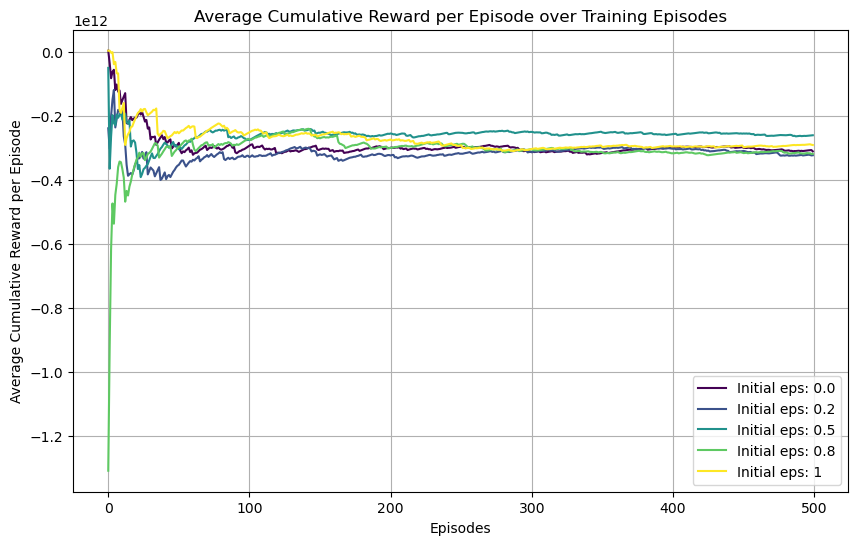

In [33]:
# Define a function which simulates one episode of agent-environment interaction
def run_episode(model, env):
    """
    Perform one episode of 8 timesteps with the given model in the provided environment.
    """
    obs = env.reset()
    rewards = []
    current_average_rewards = []  # Store average rewards for current epsilon

    for _ in range(8):  
        action, _states = model.predict(obs, deterministic=True)
        charging_power = env.charging_powers[action]
        obs, reward, done, info = env.step(action)
        energy_met = info['energy_met']
        instant_reward = info['instant_reward']
        rewards.append(instant_reward)
        average_reward = sum(rewards) / len(rewards)
        current_average_rewards.append(average_reward)
        
        print(f"Action: {action}, Charging Power: {charging_power} kW, Reward: {reward}")
        print(f"Current Battery Level: {obs[1]} kWh")
        
        if done:
            print(f"Energy Demand Met: {energy_met}")
            print(f"Missed Demand: {info['missed_demand']} kWh")  # Display missed demand

    return current_average_rewards


from stable_baselines3.common.callbacks import BaseCallback

# Define a custom callback to store rewards per episode.
class RewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLogger, self).__init__(verbose)
        self.current_episode_reward = 0
        self.rewards_per_episode = []

    def _on_step(self) -> bool:
        self.current_episode_reward += self.training_env.get_attr('cumulative_reward')[0]
        if (self.num_timesteps % 8) == 0:  # Every 8 steps is an episode
            self.rewards_per_episode.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        return True

# Define parameters for training loop
initial_eps_values = [0.0, 0.2, 0.5, 0.8, 1]
env = ChargingEnvironment()
rewards_per_eps = {}  # Store rewards for each value of initial_eps

# For each parameter: Train a model and perform episodes with trained policy
n_episodes_train = 500
for initial_eps in initial_eps_values:
    model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.005, exploration_initial_eps=initial_eps, exploration_final_eps=initial_eps)
    
    reward_logger = RewardLogger()
    model.learn(total_timesteps=n_episodes_train*8, callback=reward_logger)
    rewards_per_eps[initial_eps] = reward_logger.rewards_per_episode
    model.save(f"dqn_model_eps_{initial_eps}")

colormap = plt.get_cmap('viridis')
colors = [colormap(i) for i in np.linspace(0, 1, len(initial_eps_values))]

plt.figure(figsize=(10, 6))

# Plot average cumulative rewards per episode for all initial_eps values
for idx, initial_eps in enumerate(initial_eps_values):
    cumulative_mean_per_episode = np.cumsum(rewards_per_eps[initial_eps]) / (np.arange(len(rewards_per_eps[initial_eps])) + 1)
    plt.plot(cumulative_mean_per_episode, label=f'Initial eps: {initial_eps}', color=colors[idx])

plt.xlabel('Episodes')
plt.ylabel('Average Cumulative Reward per Episode')
plt.legend()
plt.title('Average Cumulative Reward per Episode over Training Episodes')
plt.grid(True)
plt.savefig("average_cumulative_reward.png")  # Save the figure
plt.show()

In [34]:
# Function for post-training model simulation / evaluation 
# Also provides simulation functionality of random uniform and fixed policy models for comparison 
def simulate_policy(model_or_policy, n_episodes, is_fixed_policy=False):
    
    # Initialise environent and relevant metrics 
    env = ChargingEnvironment() 
    total_rewards = []
    cumulative_rewards = []
    actions_taken = []
    n_energy_demand_not_met = 0
    charging_costs = []
    missed_demands = 0

    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        cumulative_reward = 0
        actions = []
        total_charging_cost = 0

        while not done:
            if is_fixed_policy:
                if model_or_policy == 'always_0':
                    action = 0
                elif model_or_policy == 'always_1':
                    action = 1
                elif model_or_policy == 'always_2':
                    action = 2
                elif model_or_policy == 'always_3':
                    action = 3
                elif model_or_policy == 'uniform':
                    action = np.random.choice([0, 1, 2, 3])
            else:
                action, _ = model_or_policy.predict(obs, deterministic=True)
            
            obs, reward, done, info = env.step(action)
            missed_demands += info['missed_demand']
            total_reward += reward
            actions.append(action)
            total_charging_cost += info['charging_cost']

        total_rewards.append(total_reward)
        cumulative_reward = sum(total_rewards) / len(total_rewards)
        cumulative_rewards.append(cumulative_reward)
        actions_taken.append(actions)
        charging_costs.append(total_charging_cost + (charging_costs[-1] if charging_costs else 0))

        if info['energy_met'] == False:
            n_energy_demand_not_met += 1

    return total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demands

In [35]:
colormap = plt.get_cmap('viridis')
colors = [colormap(i) for i in np.linspace(0, 1, len(initial_eps_values))]


In [36]:
# Define simulation models
model_files = ["dqn_model_eps_0.0", "dqn_model_eps_0.2", "dqn_model_eps_0.5", "dqn_model_eps_0.8", "dqn_model_eps_1"]
fixed_policies = ["always_0", "always_1", "always_2", "always_3", "uniform"]

# Number of simulation episodes
n_sim_episodes = 1000 

# Initialise lists for relevant metrics
all_actions_taken = []
total_accumulated_rewards = []
energy_demand_not_met_counts = []
all_cumulative_rewards = []
all_charging_costs = []
all_missed_demands = []

# Simulation loops for all parameters / policies
# RL models
for model_file in model_files:
    model = DQN.load(model_file)
    total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demand = simulate_policy(model, n_sim_episodes)
    all_actions_taken.append(actions_taken)
    total_accumulated_rewards.append(sum(total_rewards))
    energy_demand_not_met_counts.append(n_energy_demand_not_met)
    all_cumulative_rewards.append(cumulative_rewards)
    all_charging_costs.append(charging_costs)
    all_missed_demands.append(missed_demand)

# Fixed policies
for policy in fixed_policies:
    total_rewards, cumulative_rewards, actions_taken, n_energy_demand_not_met, charging_costs, missed_demand = simulate_policy(policy, n_sim_episodes, is_fixed_policy=True)
    all_actions_taken.append(actions_taken)
    total_accumulated_rewards.append(sum(total_rewards))
    energy_demand_not_met_counts.append(n_energy_demand_not_met)
    all_cumulative_rewards.append(cumulative_rewards)
    all_charging_costs.append(charging_costs)
    all_missed_demands.append(missed_demand)

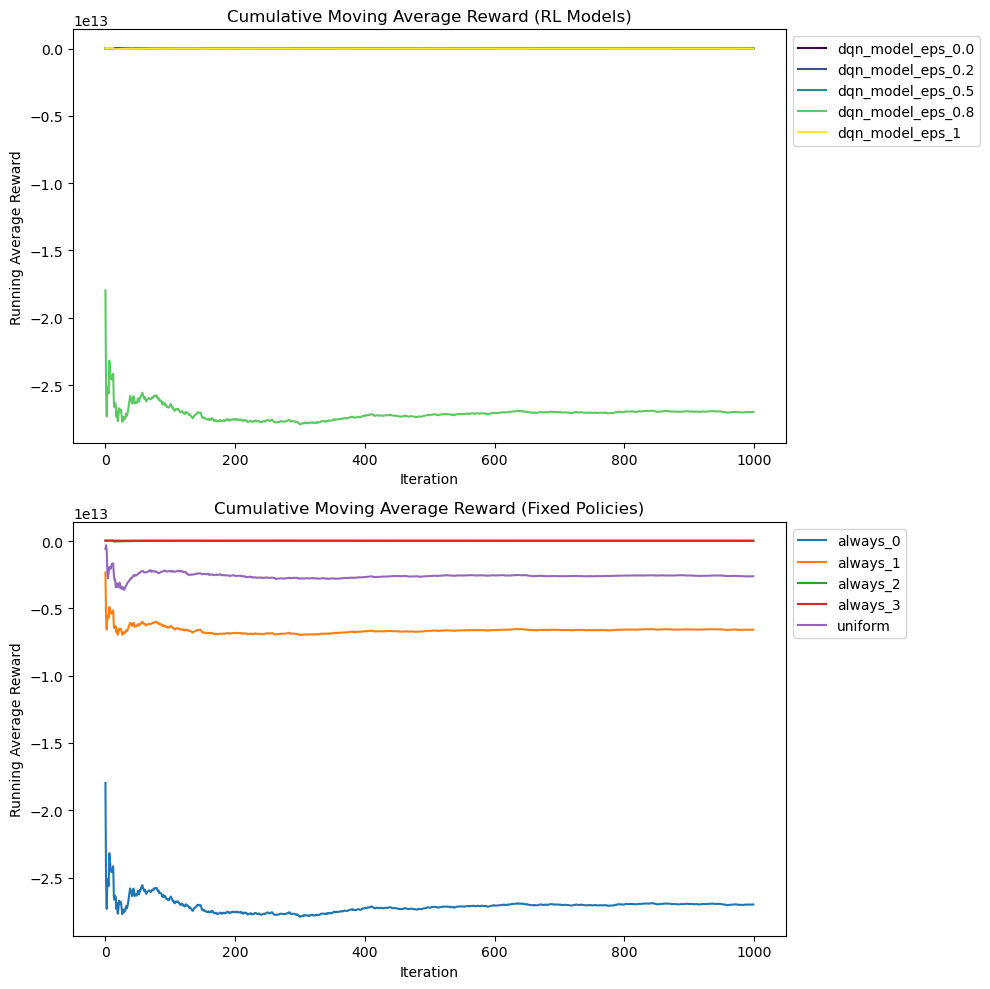

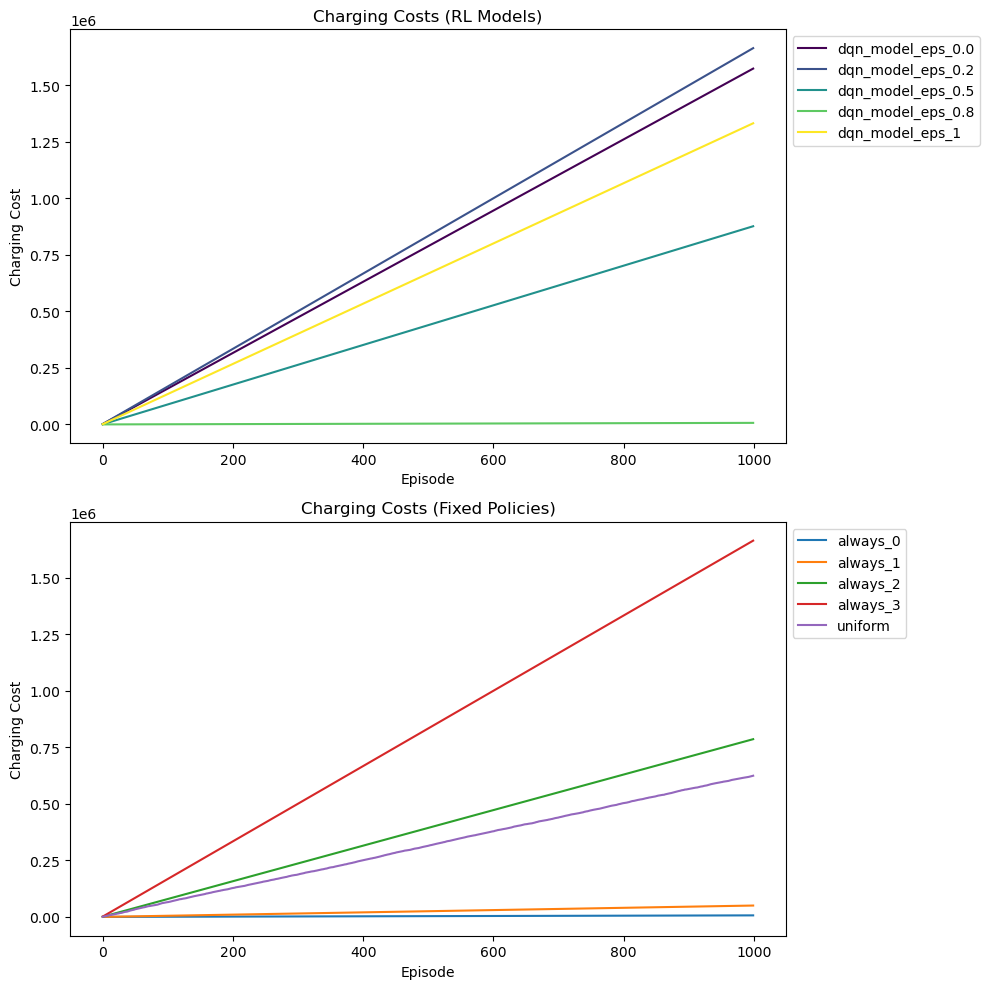

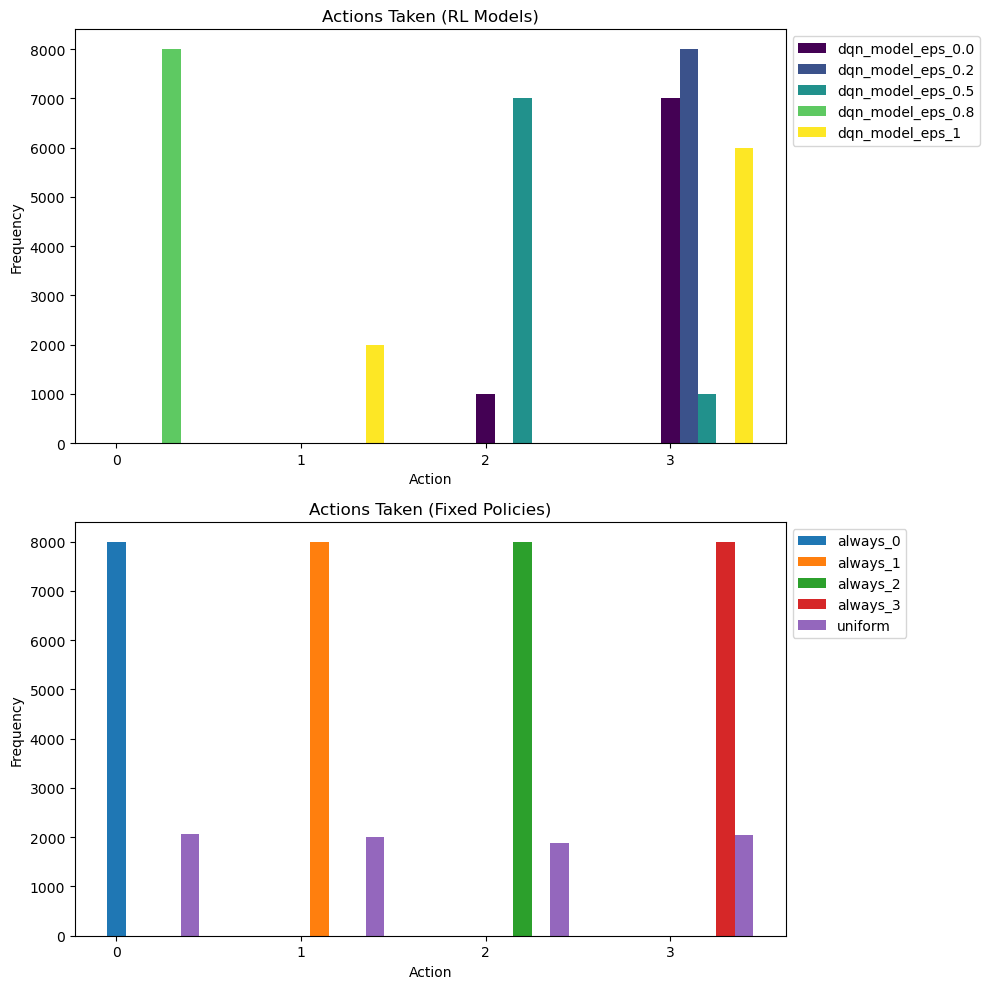

In [37]:
# PLOTS
n_models = 5

# 1. Running Average Rewards
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RL Models
for idx, model_file in enumerate(model_files):
    axes[0].plot(all_cumulative_rewards[idx], label=model_file, color=colors[idx])

# Fixed Policies
for idx, policy_name in enumerate(fixed_policies, start=n_models):
    axes[1].plot(all_cumulative_rewards[idx], label=policy_name)

axes[0].set_title('Cumulative Moving Average Reward (RL Models)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Running Average Reward')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

axes[1].set_title('Cumulative Moving Average Reward (Fixed Policies)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Running Average Reward')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

plt.tight_layout()
fig.savefig('running_average_rewards.png')  # Save the figure
plt.show()

# 2. Charging Costs
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RL Models
for idx, model_file in enumerate(model_files):
    axes[0].plot([-1 * val for val in all_charging_costs[idx]], label=model_file, color=colors[idx])

# Fixed Policies
for idx, policy_name in enumerate(fixed_policies, start=n_models):
    axes[1].plot([-1 * val for val in all_charging_costs[idx]], label=policy_name)

axes[0].set_title('Charging Costs (RL Models)')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Charging Cost')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

axes[1].set_title('Charging Costs (Fixed Policies)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Charging Cost')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

plt.tight_layout()
fig.savefig('charging_costs.png')
plt.show()

# 3. Action Distribution
x = np.arange(env.action_space.n)
width = 0.1

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RL Models
for i, model_file in enumerate(model_files):
    actions = all_actions_taken[i]
    action_counts = np.zeros(env.action_space.n)
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts
    # Normalize color based on position in list
    color = colors[i]
    axes[0].bar(x + (i * width), action_counts, width=width, label=model_file, color=color)

# Fixed Policies
for i, policy_name in enumerate(fixed_policies, start=n_models):
    actions = all_actions_taken[i]
    action_counts = np.zeros(env.action_space.n)
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts
    axes[1].bar(x + ((i - n_models) * width), action_counts, width=width, label=policy_name)

axes[0].set_title('Actions Taken (RL Models)')
axes[0].set_xlabel('Action')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(x)
axes[0].set_xticklabels(range(env.action_space.n))
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

axes[1].set_title('Actions Taken (Fixed Policies)')
axes[1].set_xlabel('Action')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(range(env.action_space.n))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

plt.tight_layout()
fig.savefig('action_distribution.png')
plt.show()


In [38]:
# Initialize the dataframe
agent_names = model_files + fixed_policies
actions_cols = range(env.action_space.n)
action_distribution_df = pd.DataFrame(index=agent_names, columns=actions_cols, dtype=float)

for idx, agent in enumerate(agent_names):
    actions = all_actions_taken[idx]
    action_counts = np.zeros(env.action_space.n)
    
    for actions_iter in actions:
        unique_actions, counts = np.unique(actions_iter, return_counts=True)
        action_counts[unique_actions] += counts

    # Convert action counts to percentages
    action_percentages = (action_counts / sum(action_counts)) * 100
    action_distribution_df.loc[agent] = action_percentages

# Display the DataFrame
action_distribution_df


,0,1,2,3
dqn_model_eps_0.0,0.00,0.00,12.50,87.50
dqn_model_eps_0.2,0.00,0.00,0.00,100.00
dqn_model_eps_0.5,0.00,0.00,87.50,12.50
dqn_model_eps_0.8,100.00,0.00,0.00,0.00
dqn_model_eps_1,0.00,25.00,0.00,75.00
always_0,100.00,0.00,0.00,0.00
always_1,0.00,100.00,0.00,0.00
always_2,0.00,0.00,100.00,0.00
always_3,0.00,0.00,0.00,100.00
uniform,25.74,25.14,23.56,25.56


In [39]:
# SUMMARY TABLES
# Find the best (minimum) total charging cost among RL models
best_charging_cost_rl = min([-all_charging_costs[i][-1] for i in range(4)])
best_charging_cost_fixed = min([-all_charging_costs[i][-1] for i in range(5, 10)])
import pandas as pd

# Format the floating point numbers in DataFrames
pd.set_option('display.float_format', '{:.2f}'.format)

# Compute table for the RL models
data_list = []

for i, model_file in enumerate(model_files):
    print(i)
    total_accumulated_reward = total_accumulated_rewards[i]
    relative_comparison = total_accumulated_reward / max(total_accumulated_rewards[0:5])
    energy_demand_not_met = energy_demand_not_met_counts[i]
    average_reward = total_accumulated_reward / n_sim_episodes
    total_cost = -all_charging_costs[i][-1]
    relative_charging_cost_comparison = total_cost / best_charging_cost_rl
    total_missed_demand = all_missed_demands[i]
    # total_penalty = total_cost - total_accumulated_reward
    avg_missed_demand_per_occurrence = total_missed_demand / energy_demand_not_met if energy_demand_not_met != 0 else 0

    data_list.append({
        "Model": model_file,
        #"Total Cumulative Reward": total_accumulated_reward,
        "Average Reward": average_reward,
        #"Comparison Factor (Total Reward / Max(Total Reward))": relative_comparison,
        "No. of days with unmatched demand": energy_demand_not_met,
        "Total Charging Cost": total_cost,
        #"Charging Cost Comparison": relative_charging_cost_comparison,        
        # "Total Penalty": total_penalty,
        "Total Missed Demand (kW)": total_missed_demand,
        "Avg Missed Demand/Occurrence": avg_missed_demand_per_occurrence,
    })

# Convert to DataFrame
rl_df = pd.DataFrame(data_list)

# Compute table for the fixed policies
data_list_fixed_policies = []

for i, policy_name in enumerate(fixed_policies, start=n_models):
    print(i)
    total_accumulated_reward = total_accumulated_rewards[i]
    relative_comparison = total_accumulated_reward / max(total_accumulated_rewards[5:9])
    energy_demand_not_met = energy_demand_not_met_counts[i]
    average_reward = total_accumulated_reward / n_sim_episodes
    total_cost = -all_charging_costs[i][-1]
    relative_charging_cost_comparison = total_cost / best_charging_cost_fixed
    total_missed_demand = all_missed_demands[i]
    # total_penalty = total_cost - total_accumulated_reward
    avg_missed_demand_per_occurrence = total_missed_demand / energy_demand_not_met if energy_demand_not_met != 0 else 0

    data_list_fixed_policies.append({
        "Model": policy_name,
        #"Total Cumulative Reward": total_accumulated_reward,
        "Average Reward": average_reward,
        #"Comparison Factor (Total Reward / Max(Total Reward))": relative_comparison,
        "No. of days with unmatched demand": energy_demand_not_met,
        "Total Charging Cost": total_cost,
        #"Charging Cost Comparison": relative_charging_cost_comparison,
        # "Total Penalty": total_penalty,
        "Total Missed Demand (kW)": total_missed_demand,
        "Avg Missed Demand/Occurrence": avg_missed_demand_per_occurrence
    })

# Convert to DataFrame
fixed_policies_df = pd.DataFrame(data_list_fixed_policies)

0
1
2
3
4
5
6
7
8
9


In [40]:
rl_df.sort_values(by='No. of days with unmatched demand', ascending=True)

,Model,Average Reward,No. of days with unmatched demand,Total Charging Cost,Total Missed Demand (kW),Avg Missed Demand/Occurrence
1,dqn_model_eps_0.2,28468259379.08,3,1663905.14,3.40,1.13
0,dqn_model_eps_0.0,28235629152.75,4,1573529.79,6.22,1.55
2,dqn_model_eps_0.5,17243733093.17,50,876348.49,102.44,2.05
4,dqn_model_eps_1,127201644.31,95,1331681.11,225.44,2.37
3,dqn_model_eps_0.8,-27003321048252.93,1000,6800.00,30246.76,30.25


In [41]:
fixed_policies_df.sort_values(by='No. of days with unmatched demand', ascending=True)

,Model,Average Reward,No. of days with unmatched demand,Total Charging Cost,Total Missed Demand (kW),Avg Missed Demand/Occurrence
3,always_3,28468259379.08,3,1663905.14,3.40,1.13
2,always_2,11506502447.23,65,785973.13,146.40,2.25
4,uniform,-2613631247594.72,778,624343.73,7062.07,9.08
1,always_1,-6585733940650.21,995,50245.58,14256.77,14.33
0,always_0,-27003321048252.93,1000,6800.00,30246.76,30.25


In [42]:
# Concatenate RL and fixed policies dataframes
merged_df = pd.concat([rl_df, fixed_policies_df], ignore_index=True)

# If you want to sort the merged dataframe by any specific column (e.g., 'No. of days with unmatched demand')
sorted_merged_df = merged_df.sort_values(by='No. of days with unmatched demand')

sorted_merged_df


,Model,Average Reward,No. of days with unmatched demand,Total Charging Cost,Total Missed Demand (kW),Avg Missed Demand/Occurrence
1,dqn_model_eps_0.2,28468259379.08,3,1663905.14,3.40,1.13
8,always_3,28468259379.08,3,1663905.14,3.40,1.13
0,dqn_model_eps_0.0,28235629152.75,4,1573529.79,6.22,1.55
2,dqn_model_eps_0.5,17243733093.17,50,876348.49,102.44,2.05
7,always_2,11506502447.23,65,785973.13,146.40,2.25
4,dqn_model_eps_1,127201644.31,95,1331681.11,225.44,2.37
9,uniform,-2613631247594.72,778,624343.73,7062.07,9.08
6,always_1,-6585733940650.21,995,50245.58,14256.77,14.33
3,dqn_model_eps_0.8,-27003321048252.93,1000,6800.00,30246.76,30.25
5,always_0,-27003321048252.93,1000,6800.00,30246.76,30.25


In [43]:
# Identify the model with the minimum number of days with unmatched demand
min_unmatched_demand = merged_df['No. of days with unmatched demand'].min()
base_model = merged_df[merged_df['No. of days with unmatched demand'] == min_unmatched_demand].iloc[0]

# Use its charging cost as the base (denominator) for the charging cost comparison
base_charging_cost = base_model['Total Charging Cost']

# Compute the charging cost comparison for all models relative to this base charging cost
merged_df['Cost Comparison Ratio (w.r.t. Model with minimum unmatched demand)'] = merged_df['Total Charging Cost'] / base_charging_cost

# Display the updated merged dataframe
merged_df.sort_values(by='No. of days with unmatched demand')


,Model,Average Reward,No. of days with unmatched demand,Total Charging Cost,Total Missed Demand (kW),Avg Missed Demand/Occurrence,Cost Comparison Ratio (w.r.t. Model with minimum unmatched demand)
1,dqn_model_eps_0.2,28468259379.08,3,1663905.14,3.40,1.13,1.00
8,always_3,28468259379.08,3,1663905.14,3.40,1.13,1.00
0,dqn_model_eps_0.0,28235629152.75,4,1573529.79,6.22,1.55,0.95
2,dqn_model_eps_0.5,17243733093.17,50,876348.49,102.44,2.05,0.53
7,always_2,11506502447.23,65,785973.13,146.40,2.25,0.47
4,dqn_model_eps_1,127201644.31,95,1331681.11,225.44,2.37,0.80
9,uniform,-2613631247594.72,778,624343.73,7062.07,9.08,0.38
6,always_1,-6585733940650.21,995,50245.58,14256.77,14.33,0.03
3,dqn_model_eps_0.8,-27003321048252.93,1000,6800.00,30246.76,30.25,0.00
5,always_0,-27003321048252.93,1000,6800.00,30246.76,30.25,0.00


In [44]:
# Obviously: Simple environment -> In practice one would use more sophisticated agent-environment models, and more complex learning methods including optimal reward callbacks in training and multi-agent/ensemble methods.

# Interesting observation that multiple agents learn the "strategies" of always charging at the highest rate, which leads to the minimum possible number of days with unmatched demand. 

# First observation regardless of RL: Just the fixed policy agents show the tradeoff between charging costs and missed energy demand with the given environment and parameters for demand modeling.
# -> The highest charging rate (due to the exponential charging cost function) leads to very high costs, while "ensuring" the minimum possible number of episodes with unmatched demand.
# -> The medium charging rate agent leads to significantly lower costs (more than 50% less costs than highest charging rate) but misses demand on 65 episodes.
# -> Two models (eps = 0.0 and 0.5) learn mixed strategies between action 3 and 2 which lead to less costs (5 up to 47%) but also higher number of unmatched demand (4 to 50).

In [45]:
merged_df.sort_values(by='No. of days with unmatched demand', inplace=True)
merged_df.to_csv('merged_df_sorted.csv', index=False)